In [13]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import glob
from cdo import Cdo
import os
from src.Experiments_infos import Data
import xarray as xr
import numpy as np
import  matplotlib.pyplot as plt
from src.Enumerations import Season
from src.plot_funcs import plot_contourf_rotated_grid


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:

exp = Data.ICON_CNRM_EXP
cdo = Cdo()
preprocess = True


In [15]:
year_start= 1984
year_end= 2014

In [16]:
if preprocess:

    paths = sorted(glob.glob(exp.slp_path_raw+f'PMSL_*-*.ncz'))

    cdo.selyear(f'{year_start}/{year_end}',
            input = '-daymean -mergetime '+' '.join(paths),
            output = f'{exp.scratch_path}slp_reg_dummy.nc' )
             
    cdo.remapbil(exp.clustering_target_grid,
             input=  f'{exp.scratch_path}slp_reg_dummy.nc',
             output= f'{exp.scratch_path}slp_reg_CNRM_3dx3dy.nc')
             
    #os.system(f"rm {exp.scratch_path}slp_reg_dummy.nc")
    

In [17]:
    cdo.remapbil(exp.clustering_target_grid,
             input= f'-selyear,{year_start}/{year_end} -mergetime '+' '.join(exp.slp_files_raw_gcm),
             output = f'{exp.scratch_path}slp_gcm_CNRM_3dx3dy.nc' )

AttributeError: type object 'ICON_CNRM_CONTROL' has no attribute 'slp_files_raw_gcm'

In [6]:
slp_reg=xr.load_dataset(f'{exp.scratch_path}slp_reg_CNRM_3dx3dy.nc')
slp_gcm=xr.load_dataset(f'{exp.scratch_path}slp_gcm_CNRM_3dx3dy.nc')

In [7]:
#slp_reg=slp_reg.sel(time=slp_reg.time.dt.year.isin(np.arange(1986,2010)))
#slp_gcm=slp_gcm.sel(time=slp_gcm.time.dt.year.isin(np.arange(1987,2011)))

slp_reg

<xarray.Dataset> Size: 2GB
Dimensions:       (time: 11323, bnds: 2, rlat: 194, rlon: 193, nv: 4)
Coordinates:
  * time          (time) datetime64[ns] 91kB 1984-01-01T11:30:00 ... 2014-12-...
    lon           (rlat, rlon) float32 150kB 137.6 137.8 138.1 ... -39.35 -39.62
    lat           (rlat, rlon) float32 150kB 47.63 47.83 48.03 ... 52.85 52.66
  * rlon          (rlon) float32 772B -29.9 -29.6 -29.3 -29.0 ... 27.1 27.4 27.7
  * rlat          (rlat) float32 776B -24.2 -23.9 -23.6 -23.3 ... 33.1 33.4 33.7
Dimensions without coordinates: bnds, nv
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 181kB 1984-01-01 ... 2014-12-31...
    lon_bnds      (rlat, rlon, nv) float32 599kB 137.6 137.7 ... -39.6 -39.51
    lat_bnds      (rlat, rlon, nv) float32 599kB 47.56 47.63 47.7 ... 52.6 52.66
    rotated_pole  |S1 1B b''
    PMSL          (time, rlat, rlon) float32 2GB 1.021e+05 ... 1.007e+05
Attributes: (12/18)
    CDI:                       Climate Data Interface version 2.2.4 (https://...
    Conventions:               CF-1.4
    source:                    Unknown@Unknown
    institution:               Alfred Wegener Institute for Polar and Marine ...
    title:                     ICON-CLM for PolarRES
    history:                   Thu May 16 19:27:29 2024: cdo -O -s -remapbil,...
    ...                        ...
    contact:                   jan.landwehrs@awi.de
    icon-clm_version:          2.6.6
    creation_date:             2023-12-24 13:12:41 CET
    cdo_openmp_thread_number:  8
    frequency:                 day
    CDO:                       Climate Data Operators version 2.2.2 (https://...

# both NorESM datasets regridded to 30x30 km regional rotated icon grid

Season.WINTER
Season.SPRING
Season.SUMMER
Season.AUTUMN


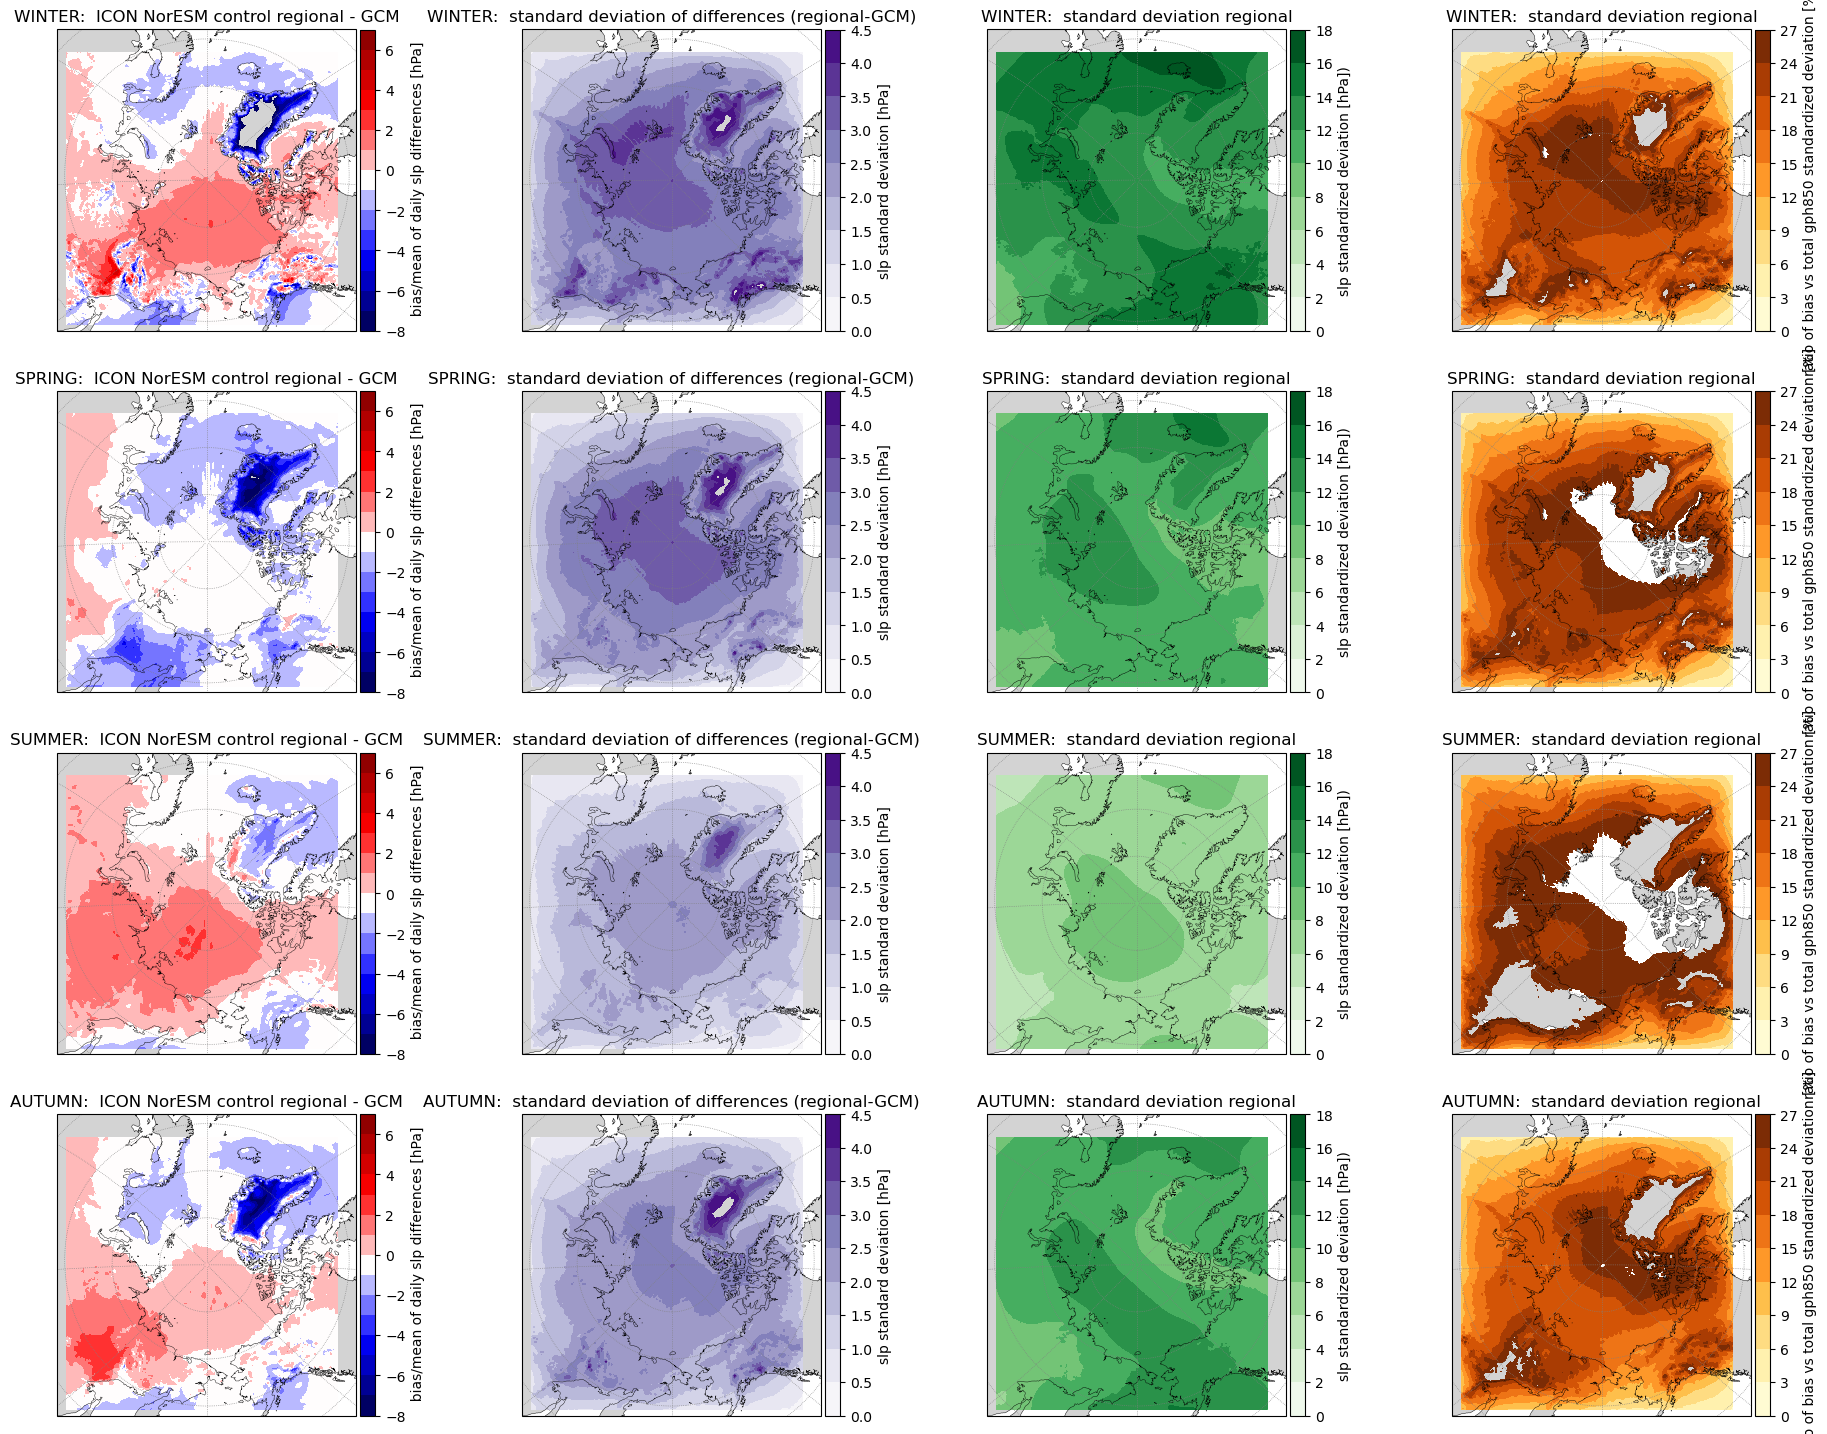

In [12]:
fig = plt.figure(figsize=(23,18))
for  season_, i in zip(Season,[0,4,8,12]):
    print (season_)
    reg_sel = slp_reg.sel(time=slp_reg.time.dt.month.isin(season_.value))
    gcm_sel = slp_gcm.sel(time=slp_gcm.time.dt.month.isin(season_.value))
    
    error = np.mean((reg_sel.PMSL.values - gcm_sel.psl.values)/100, axis=0)


    plot_contourf_rotated_grid(slp_reg.rlon.values,
                               slp_reg.rlat.values,
                               error, index =i,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name}:  ICON NorESM control regional - GCM',
                              levels =np.arange(-8,8,1),
                              cbar_label= "  bias/mean of daily slp differences [hPa] ",
                              cmap="seismic")
    
    
    std_bias = np.std((reg_sel.PMSL.values- gcm_sel.psl.values)/100,axis=0)
                  
    plot_contourf_rotated_grid(slp_reg.rlon.values,
                               slp_reg.rlat.values,
                               std_bias, index =i+1,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name}:  standard deviation of differences (regional-GCM)',
                              #levels =np.arange(0,25,2),
                              levels =np.arange(0,5,0.5),

                              cbar_label= "slp standard deviation [hPa]",
                              cmap="Purples")

    std_tot  = np.std(reg_sel.PMSL.values/100,axis=0)
    
    plot_contourf_rotated_grid(slp_reg.rlon.values,
                               slp_reg.rlat.values,
                               std_tot, index =i+2,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name}:  standard deviation regional',
                              levels =np.arange(0,20,2),
                              cbar_label= "slp standardized deviation [hPa])",
                              cmap="Greens")
    
    plot_contourf_rotated_grid(slp_reg.rlon.values,
                               slp_reg.rlat.values,
                               (std_bias/std_tot)*100, index =i+3,
                               fig = fig,
                               subplts=(4,4),
                               title=f'{season_.name}:  standard deviation regional',
                              levels =np.arange(0,30,3),
                              cbar_label= "ratio of bias vs total gph850 standardized deviation [%]",
                              cmap="YlOrBr")
